In [79]:
# import necessary libraries

import math
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn import set_config
set_config(display='diagram')  # To visualize pipelines better

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, PrecisionRecallDisplay
from xgboost import XGBClassifier

# Data Load

In [80]:
# Read the dataset
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [81]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [82]:
# data type conversions and handling missing values

data.drop('customerID', axis=1, inplace=True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)
data['SeniorCitizen'] = data['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
data['Churn'] = data['Churn'].replace({'No': 0, 'Yes': 1})

In [83]:
# Identify categorical and numerical features

cat_features = data.select_dtypes(include=['object']).columns.tolist()
num_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Features:", cat_features)
print("Numerical Features:", num_features)

Categorical Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']


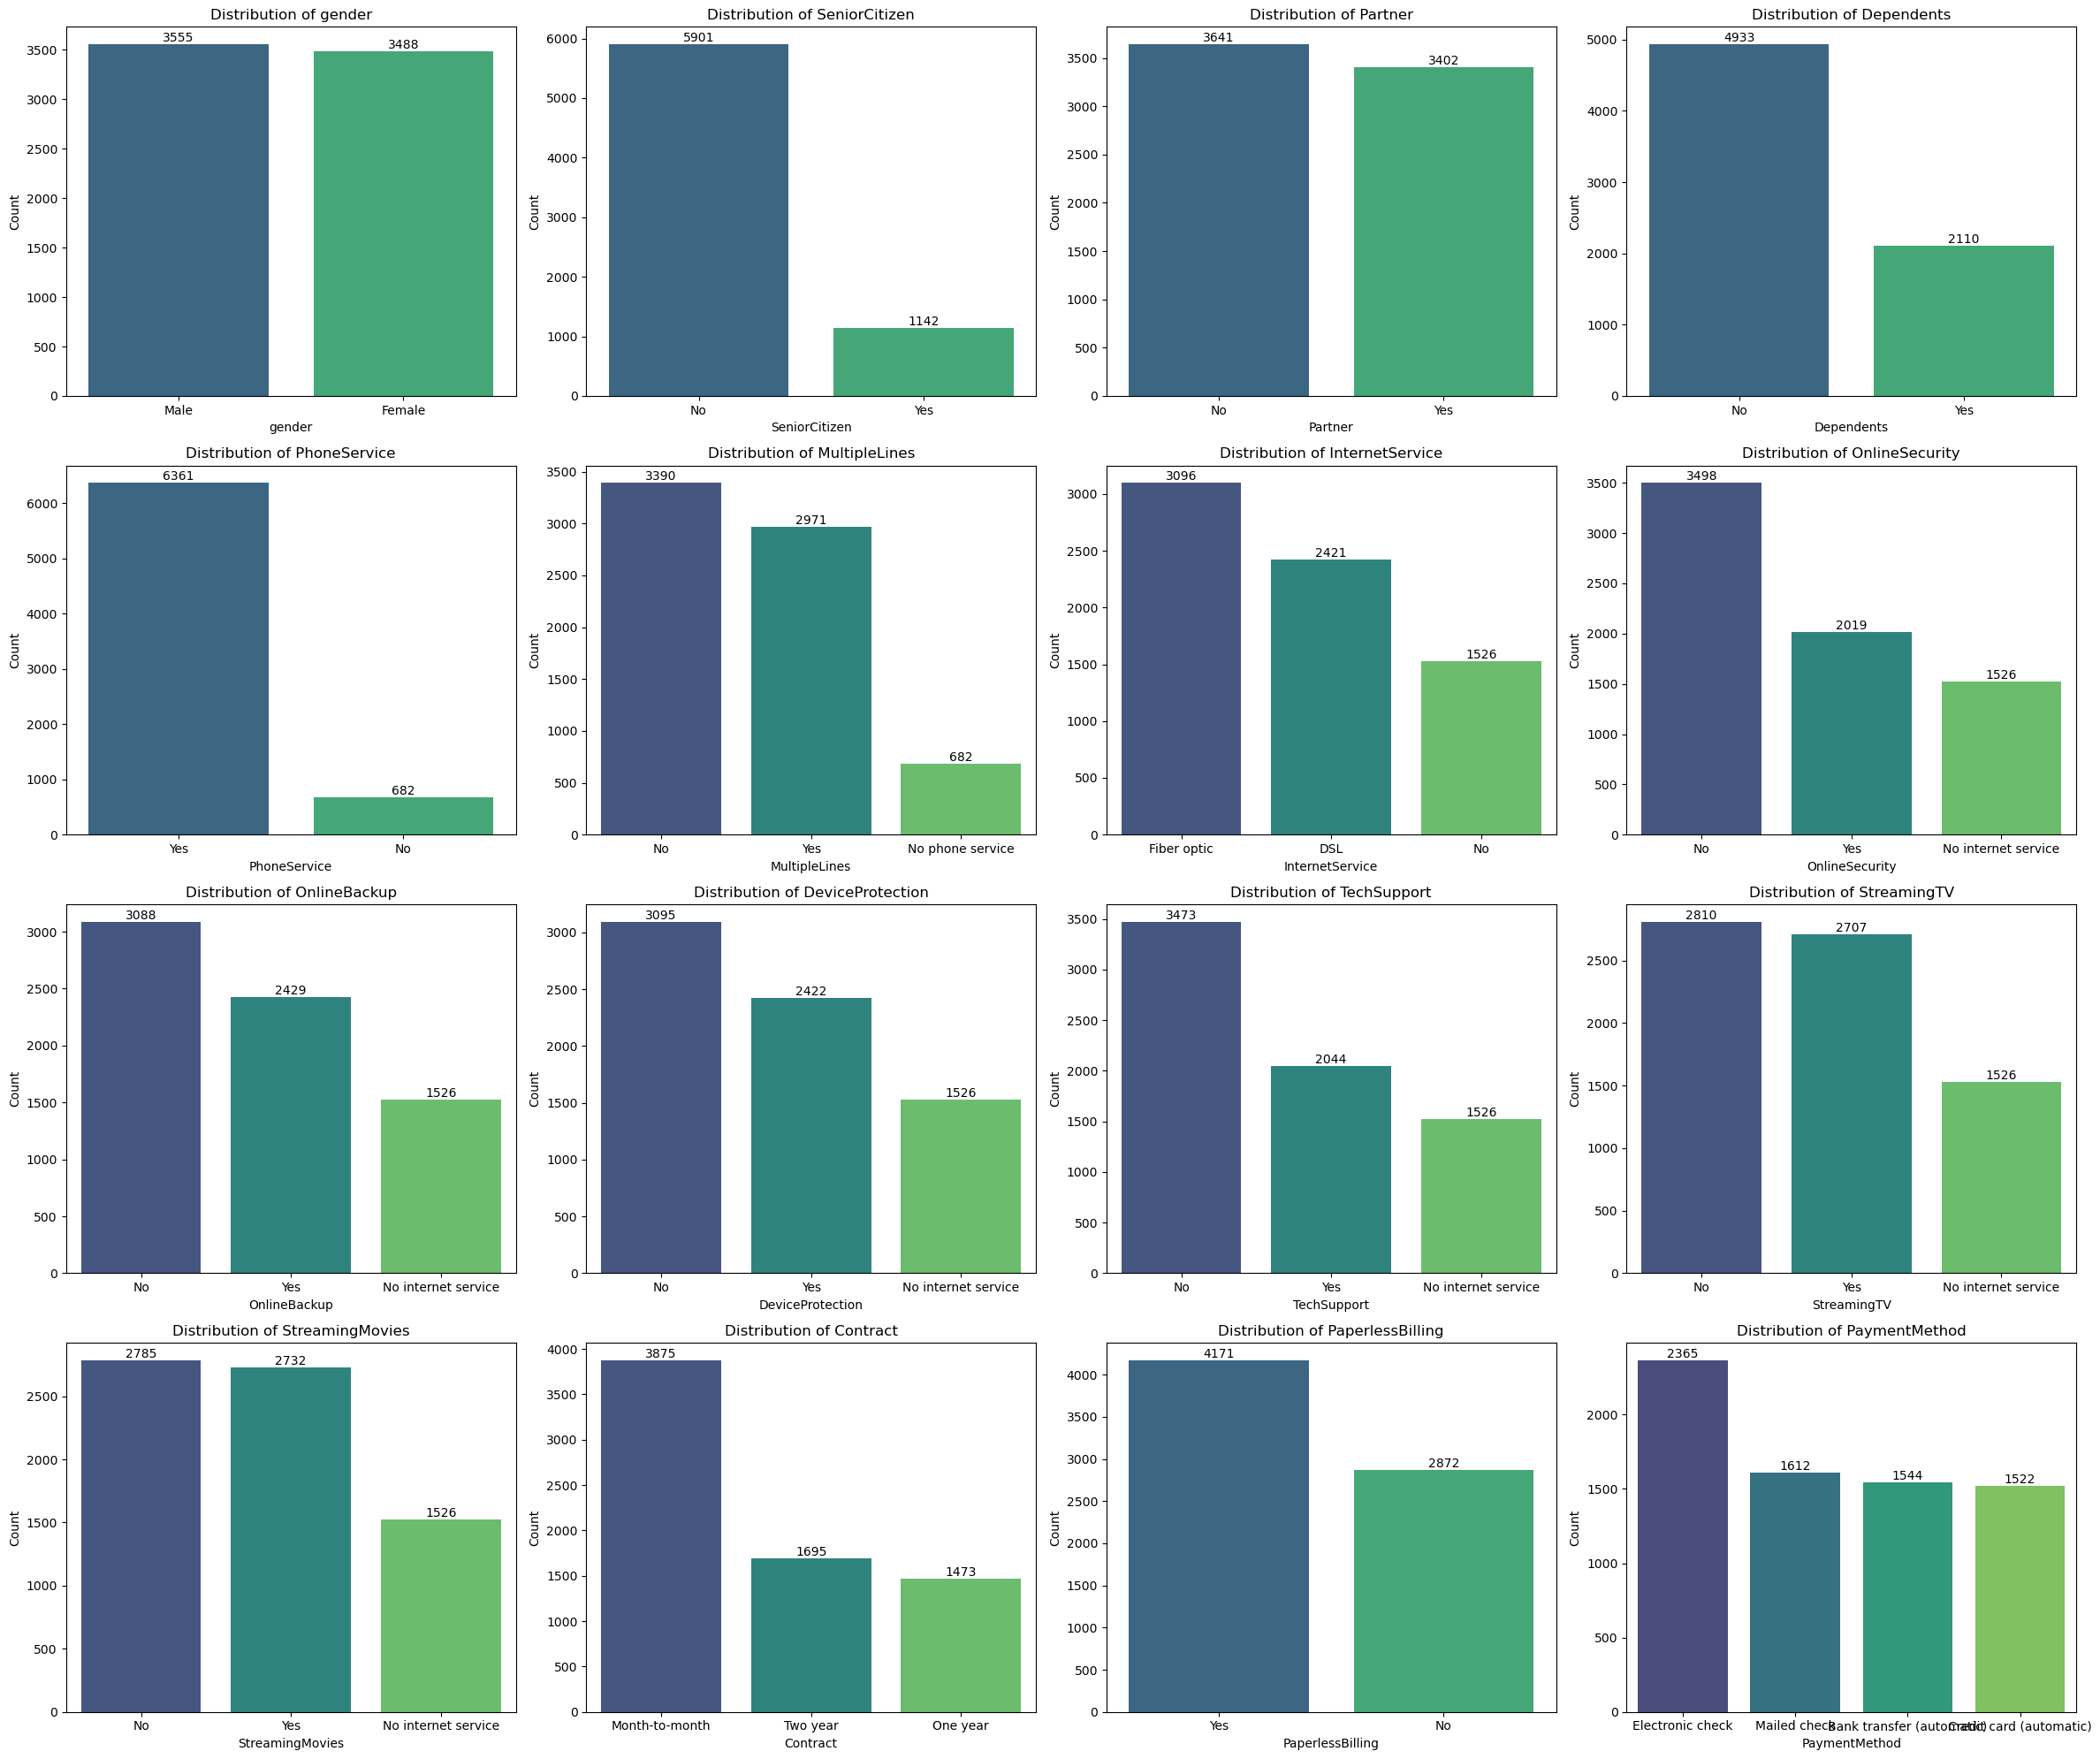

In [84]:
ncols = 4
num_rows = math.ceil(len(cat_features) / ncols) 

plt.figure(figsize=(24, 5 * num_rows)) 

for i, col in enumerate(cat_features):
    plt.subplot(num_rows, ncols, i + 1) 

    sns.countplot(x=col, data=data, palette='viridis', order=data[col].value_counts().index)
    
    plt.title(f'Distribution of {col}') 
    plt.xlabel(col)
    plt.ylabel('Count')
    
    for container in plt.gca().containers:
        plt.gca().bar_label(container)

plt.tight_layout() 
plt.show()

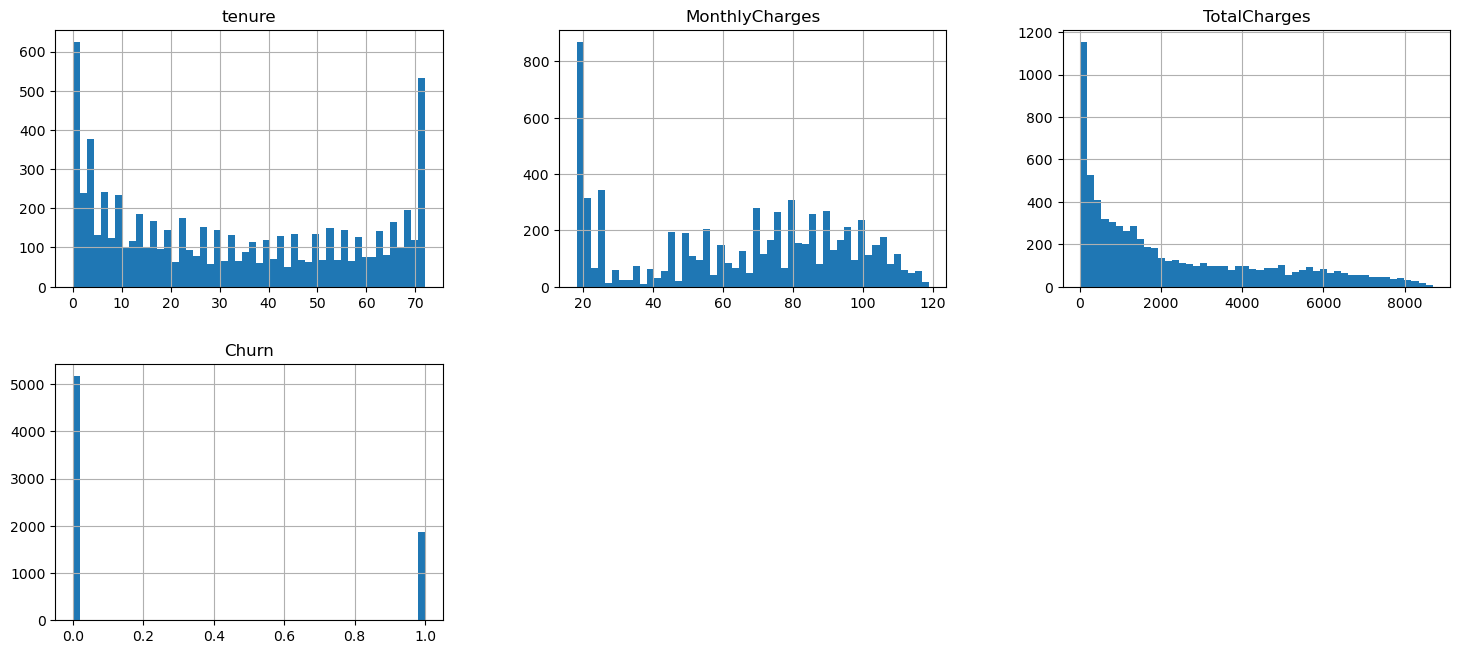

In [85]:
data.hist(bins=50, figsize=(18, 12), layout=(3, 3))
plt.show()

In [86]:
# Split the dataset into training and testing sets with stratification
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['Churn'], random_state=42)
print(f'Training set size: {train_data.shape}')
print(f'Testing set size: {test_data.shape}')

Training set size: (5634, 20)
Testing set size: (1409, 20)


In [87]:
# create a copy of the training data
data_copy = train_data.copy()

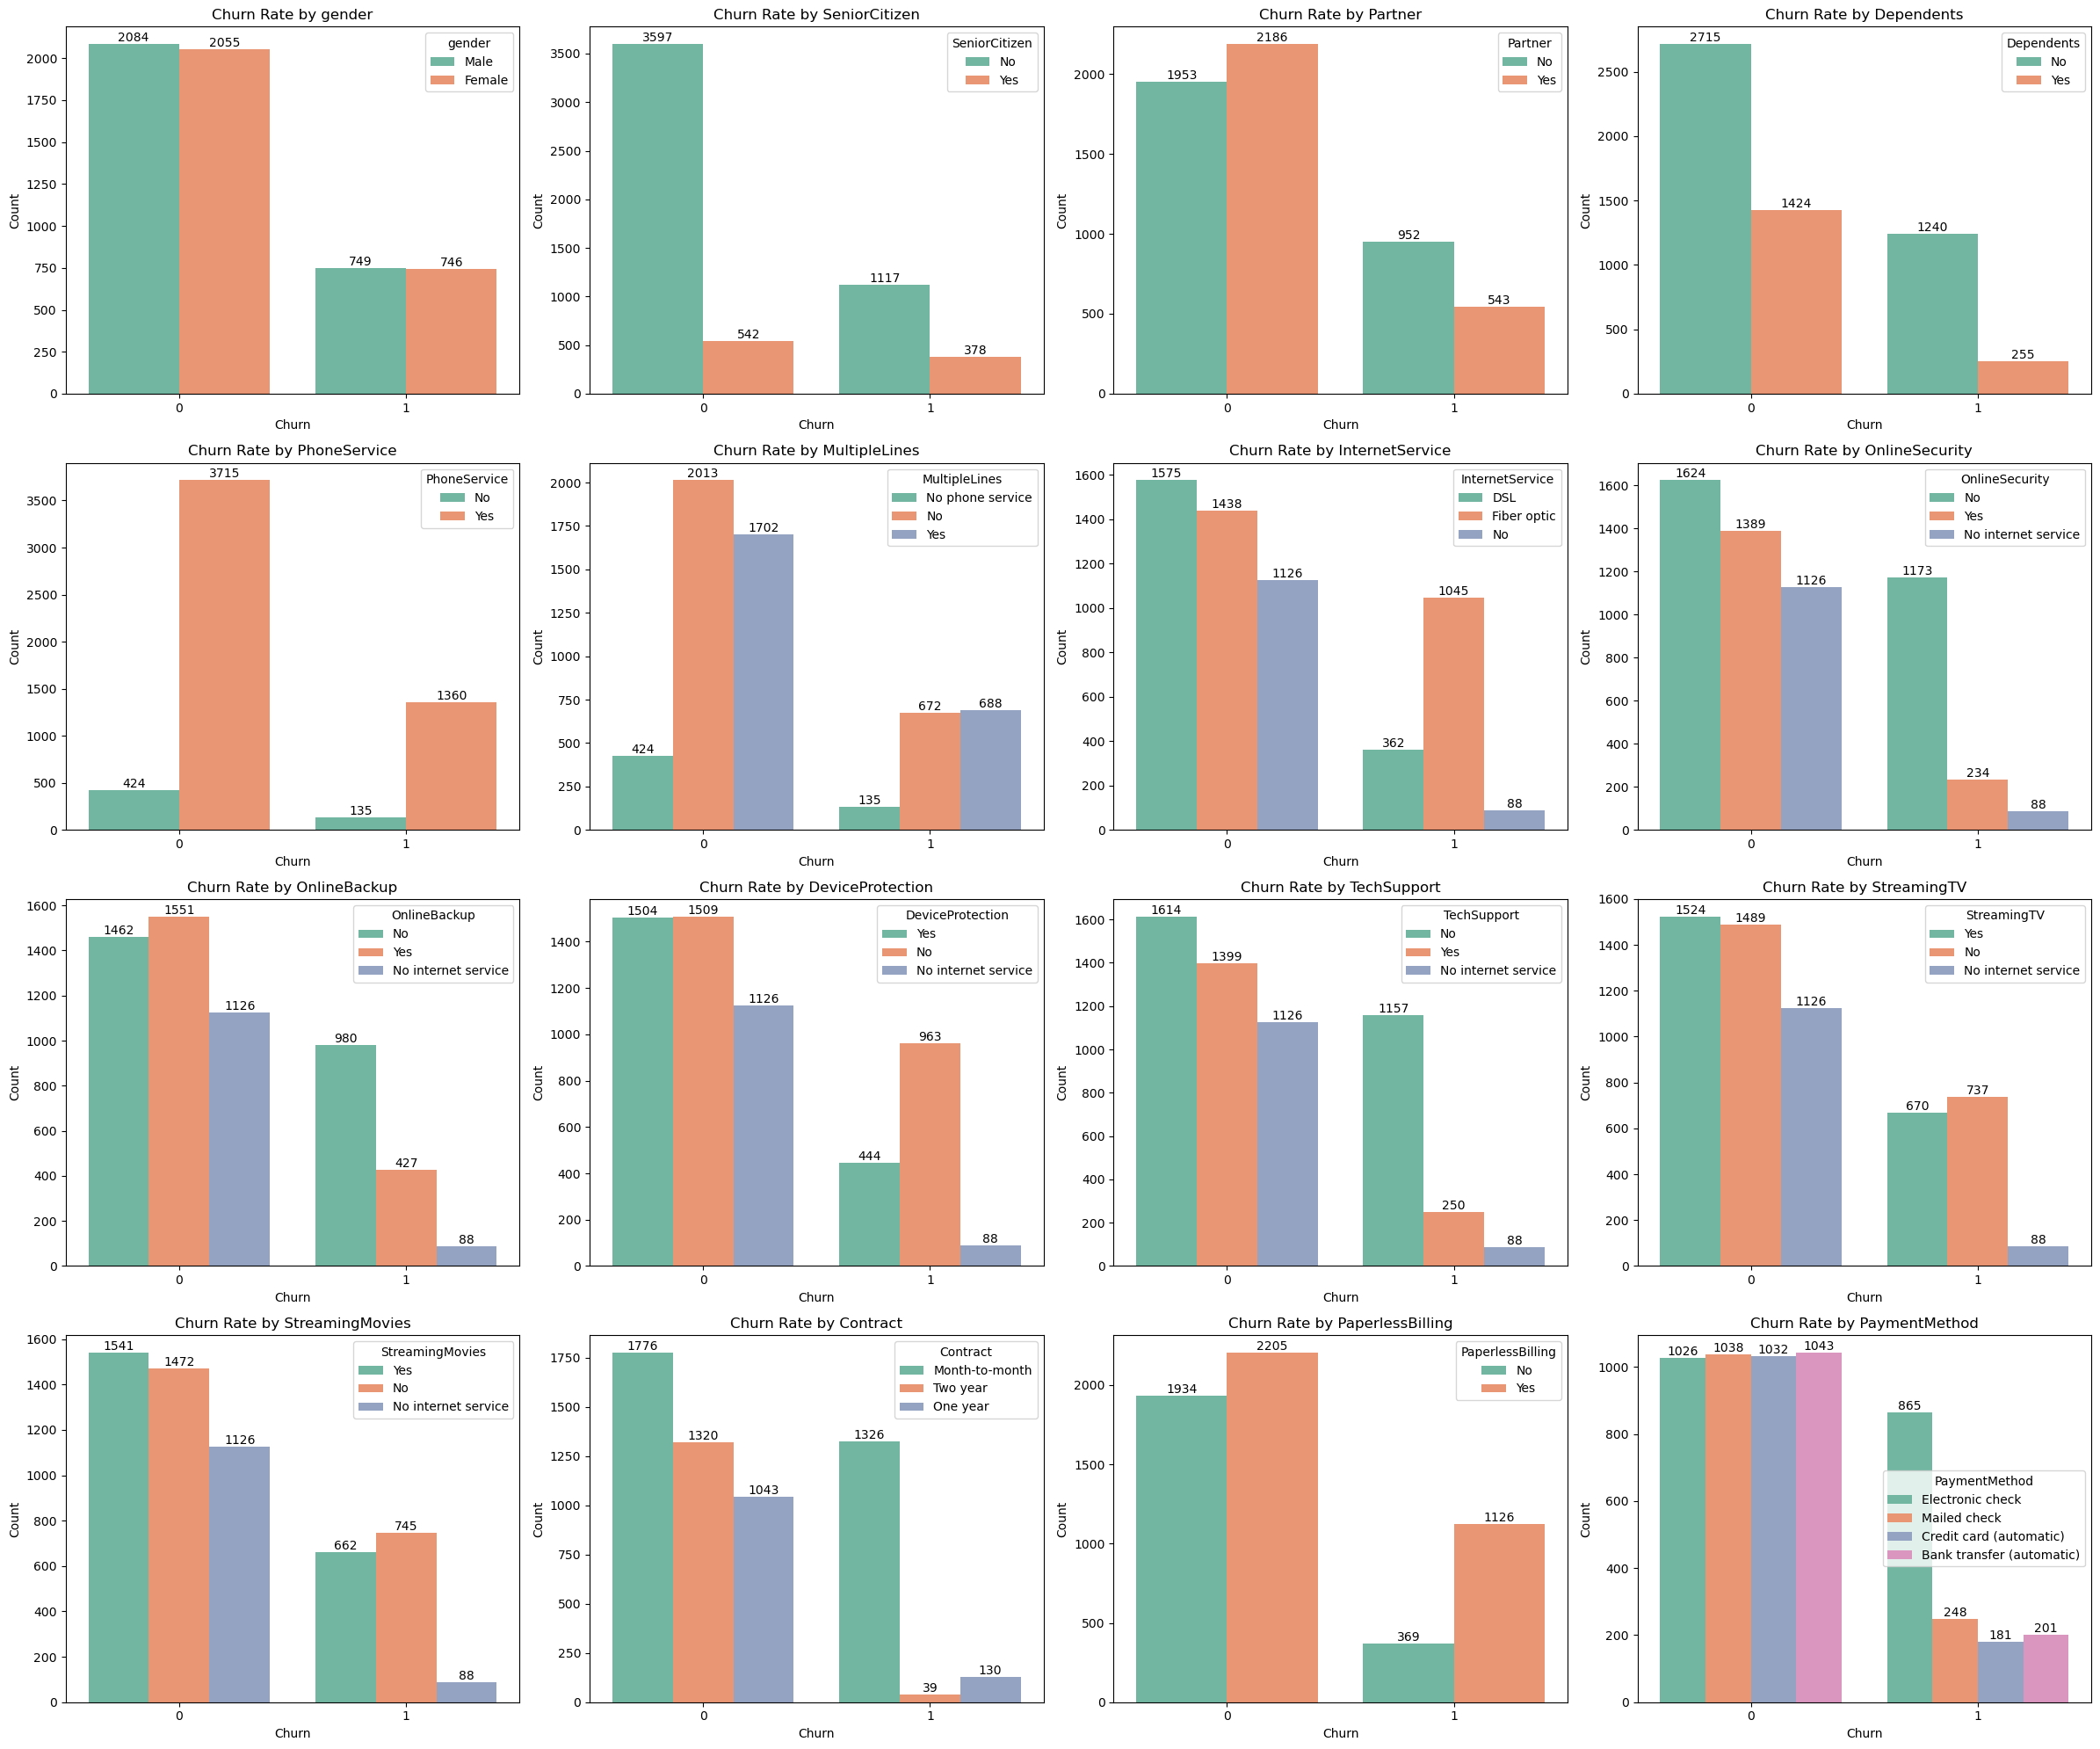

In [88]:
ncols = 4
num_rows = math.ceil(len(cat_features) / ncols) 

plt.figure(figsize=(24, 5 * num_rows)) 

for i, col in enumerate(cat_features):
    plt.subplot(num_rows, ncols, i + 1) 

    sns.countplot(x='Churn', hue=col, data=data_copy, palette='Set2', order=data_copy['Churn'].value_counts().index)
    
    plt.title(f'Churn Rate by {col}') 
    plt.xlabel('Churn')
    plt.ylabel('Count')
    
    for container in plt.gca().containers:
        plt.gca().bar_label(container)

plt.tight_layout() 
plt.show()

In [89]:
for feature in ['Contract', 'OnlineSecurity', 'TechSupport', 'OnlineBackup', 'DeviceProtection', 'PaymentMethod']:
    chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(data_copy['Churn'], data_copy[feature]))
    print("P-value for '{}' feature: {:.5f}".format(feature, p_value))
    if p_value < 0.05:
        print(">> Conclusion: Statistically significant difference between 'Churn' and '{}' exists.".format(feature))
    else:
        print(">> Conclusion: No statistically significant difference.")

P-value for 'Contract' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'Contract' exists.
P-value for 'OnlineSecurity' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'OnlineSecurity' exists.
P-value for 'TechSupport' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'TechSupport' exists.
P-value for 'OnlineBackup' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'OnlineBackup' exists.
P-value for 'DeviceProtection' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'DeviceProtection' exists.
P-value for 'PaymentMethod' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'PaymentMethod' exists.


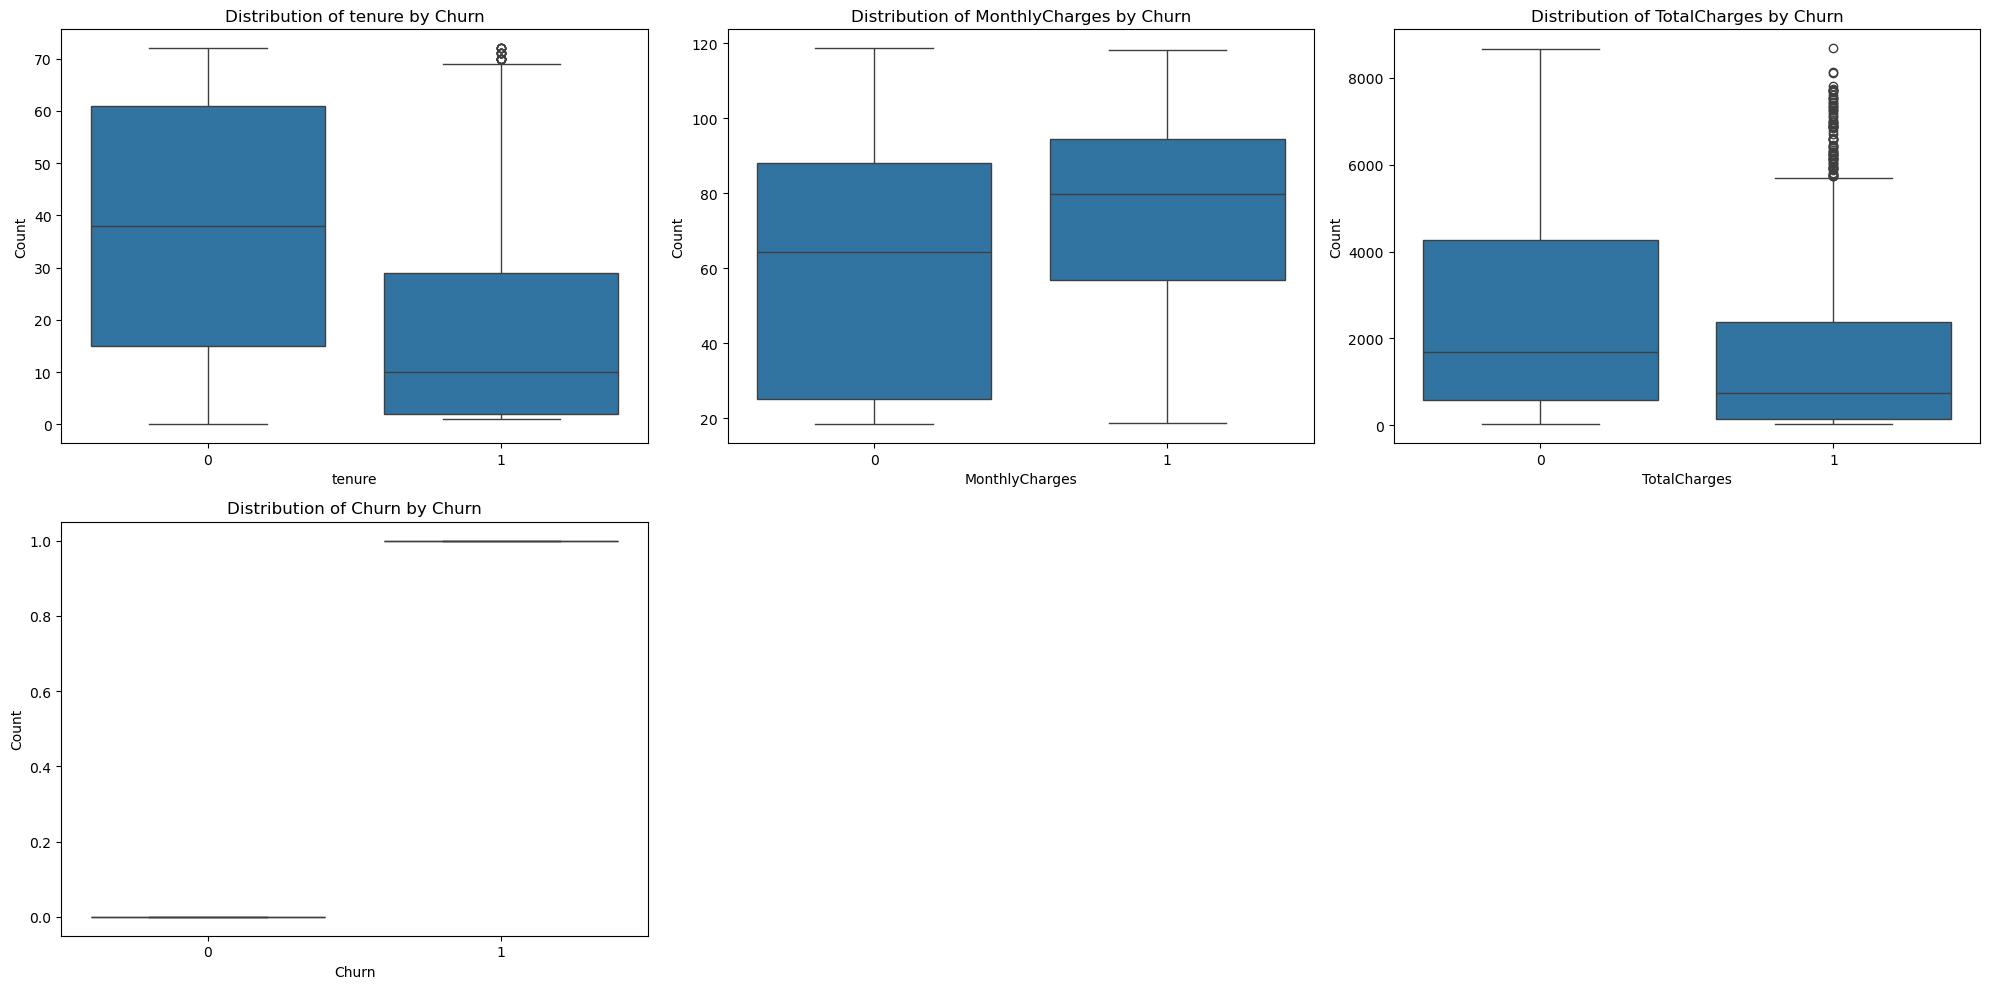

In [90]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

ncols = 3  # 수치형 변수는 보통 가로로 길게 보는 게 좋아서 열을 줄이는 걸 추천합니다.
num_rows = math.ceil(len(num_features) / ncols)

plt.figure(figsize=(20, 5 * num_rows))

for i, col in enumerate(num_features):
    plt.subplot(num_rows, ncols, i + 1)
    
    # [핵심 변경 사항]
    # countplot 대신 histplot을 사용합니다.
    # x축에는 수치형 변수(col), hue에는 타겟 변수(Churn)를 넣습니다.
    # kde=True를 설정하면 부드러운 곡선(밀도 추정)이 함께 그려집니다.
    sns.boxplot(x='Churn', y=col, data=data_copy)
    
    plt.title(f'Distribution of {col} by Churn')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

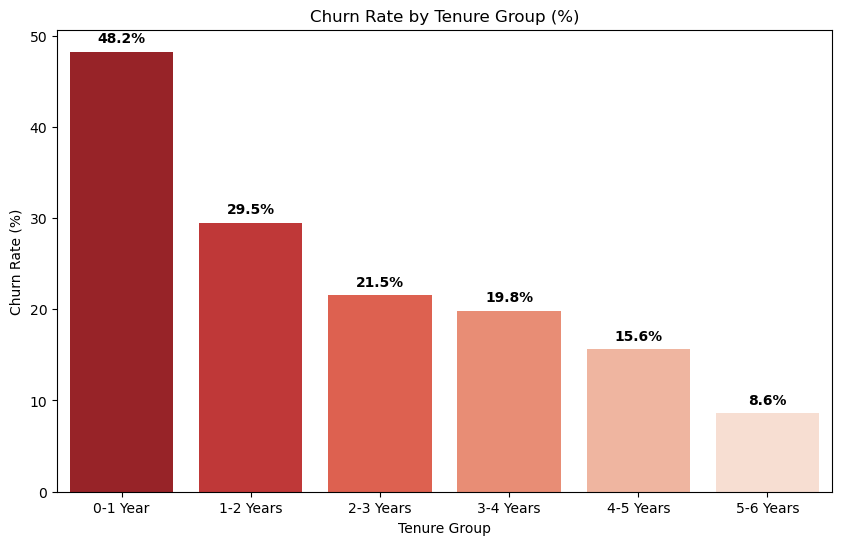

In [93]:
# 가입 기간을 1년 단위로 그룹화하여 이탈률 계산하기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 구간 설정 (0-12개월, 12-24개월 ...)
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0-1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5-6 Years']
data_copy['TenureGroup'] = pd.cut(data_copy['tenure'], bins=bins, labels=labels, right=False)

# 그룹별 이탈률 계산
churn_by_tenure = data_copy.groupby('TenureGroup')['Churn'].value_counts(normalize=True).unstack()
churn_by_tenure_yes = churn_by_tenure[1] * 100 # 백분율 변환

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_tenure_yes.index, y=churn_by_tenure_yes.values, palette='Reds_r')
plt.title('Churn Rate by Tenure Group (%)')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Tenure Group')

# 막대 위에 수치 표시
for index, value in enumerate(churn_by_tenure_yes):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', fontweight='bold')

plt.show()

### 이탈(Churn)과 가장 양의 상관관계가 높은 TOP 5 ###
tenure           NaN
MonthlyCharges   NaN
TotalCharges     NaN
Churn            NaN
gender_Female    NaN
gender_Male      NaN
Name: Churn, dtype: float64

### 이탈(Churn)과 가장 음의 상관관계가 높은(이탈을 막는) TOP 5 ###
TenureGroup_1-2 Years   NaN
TenureGroup_2-3 Years   NaN
TenureGroup_3-4 Years   NaN
TenureGroup_4-5 Years   NaN
TenureGroup_5-6 Years   NaN
Name: Churn, dtype: float64


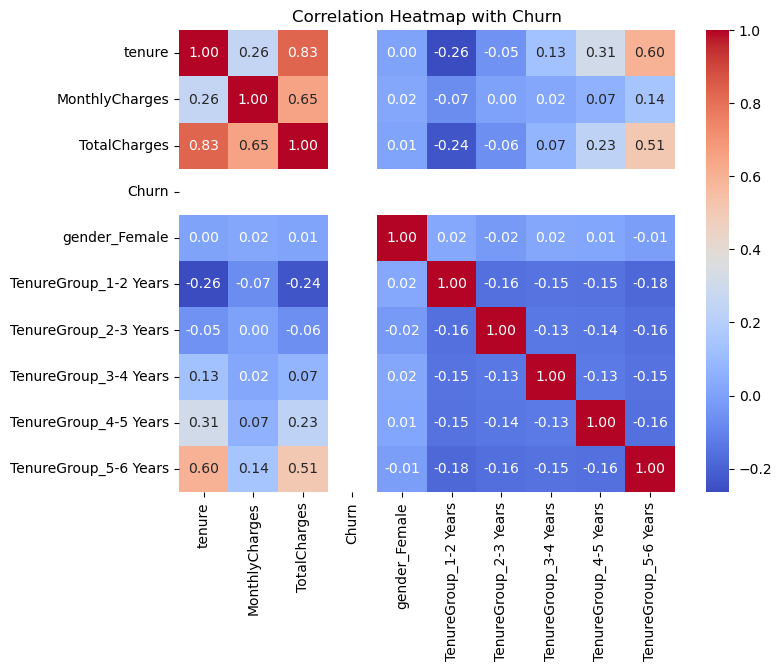

In [94]:
data_corr = data_copy.copy()

data_corr['Churn'] = data_corr['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

df_dummies = pd.get_dummies(data_corr)

correlation = df_dummies.corr()['Churn'].sort_values(ascending=False)

print("### 이탈(Churn)과 가장 양의 상관관계가 높은 TOP 5 ###")
print(correlation.head(6)) # 자기 자신(Churn) 제외하고 보기 위해
print("\n### 이탈(Churn)과 가장 음의 상관관계가 높은(이탈을 막는) TOP 5 ###")
print(correlation.tail(5))

# 시각화 (옵션)
plt.figure(figsize=(8, 6))
# 상위/하위 일부만 뽑아서 히트맵 그리기
important_features = correlation.index[:5].tolist() + correlation.index[-5:].tolist()
sns.heatmap(df_dummies[important_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap with Churn")
plt.show()

In [95]:
train_X = train_data.drop('Churn', axis=1)
train_y = train_data['Churn'].copy()

In [96]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

In [97]:
cat_features = train_X.select_dtypes(include=['object']).columns.tolist()
num_features = train_X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [98]:
preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", num_pipeline, ['tenure']),
    ("log", log_pipeline, ['MonthlyCharges', 'TotalCharges'])
])

In [99]:
train_X_preprocessed = preprocessor.fit_transform(train_X)
train_X_preprocessed.shape

(5634, 46)

In [100]:
preprocessor.get_feature_names_out()

array(['cat__gender_Female', 'cat__gender_Male', 'cat__SeniorCitizen_No',
       'cat__SeniorCitizen_Yes', 'cat__Partner_No', 'cat__Partner_Yes',
       'cat__Dependents_No', 'cat__Dependents_Yes',
       'cat__PhoneService_No', 'cat__PhoneService_Yes',
       'cat__MultipleLines_No', 'cat__MultipleLines_No phone service',
       'cat__MultipleLines_Yes', 'cat__InternetService_DSL',
       'cat__InternetService_Fiber optic', 'cat__InternetService_No',
       'cat__OnlineSecurity_No',
       'cat__OnlineSecurity_No internet service',
       'cat__OnlineSecurity_Yes', 'cat__OnlineBackup_No',
       'cat__OnlineBackup_No internet service', 'cat__OnlineBackup_Yes',
       'cat__DeviceProtection_No',
       'cat__DeviceProtection_No internet service',
       'cat__DeviceProtection_Yes', 'cat__TechSupport_No',
       'cat__TechSupport_No internet service', 'cat__TechSupport_Yes',
       'cat__StreamingTV_No', 'cat__StreamingTV_No internet service',
       'cat__StreamingTV_Yes', 'cat__Stream

In [107]:
xbgb_clf = XGBClassifier(use_label_encoder=False, 
                         eval_metric='aucpr', 
                         random_state=42
                        )

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],              
    'learning_rate': [0.01, 0.1, 0.2],   
    'subsample': [0.8, 1.0]              
    }

grid_search = GridSearchCV(
    estimator=xbgb_clf,
    param_grid=param_grid,
    scoring='f1',  
    cv=5,          
    n_jobs=-1,    
    verbose=1
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits

최적 파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
최적 F1 점수 (CV 평균): 0.5897


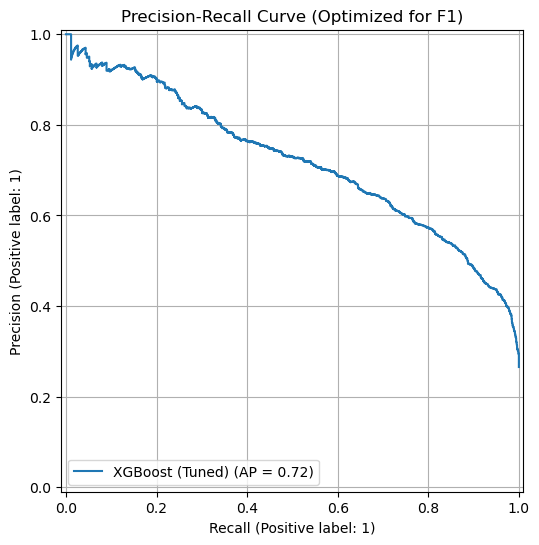

In [108]:
grid_search.fit(train_X_preprocessed, train_y)
best_model = grid_search.best_estimator_

print(f"\n최적 파라미터: {grid_search.best_params_}")
print(f"최적 F1 점수 (CV 평균): {grid_search.best_score_:.4f}")

fig, ax = plt.subplots(figsize=(8, 6))

display = PrecisionRecallDisplay.from_estimator(
    best_model,
    train_X_preprocessed,
    train_y,
    name="XGBoost (Tuned)",
    ax=ax
)

plt.title("Precision-Recall Curve (Optimized for F1)")
plt.grid(True)
plt.show()